In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
from mmcv import Config
from mmseg.apis import set_random_seed
import tqdm
import os.path as osp
from utils import intersect_and_union

print('GPU: ',torch.cuda.is_available())
print('GPU count:', torch.cuda.device_count())

data_root = '../dataset/fsd4000'
img_dir = 'Original'
ann_dir = 'Skin'
classes = ('skin','bg')
palette = [[129, 127, 38],[249, 220, 212]]

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
0.21.1
GPU:  False
GPU count: 0


## Get skin_iou with swin transformer
- Black is [0,0,0], and White is [255, 255, 255];

In [2]:
with open('../dataset/fsd4000/skin_splits/val.txt','r') as f:
    tests = f.readlines()
tests = [i.strip('\n')+'.jpg' for i in tests]

In [3]:
tests[0]

'im00975.jpg'

In [4]:
def load_swintransformer():
    # Create a config file
    cfg = Config.fromfile('mmsegmentation/configs/swin/upernet_swin_tiny_patch4_window7_512x512_160k_ade20k_pretrain_224x224_1K.py')

    # Since we use ony one GPU, BN is used instead of SyncBN
    cfg.norm_cfg = dict(type='BN', requires_grad=True)
    #cfg.model.backbone.norm_cfg = cfg.norm_cfg
    cfg.model.decode_head.norm_cfg = cfg.norm_cfg
    cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
    # modify num classes of the model in decode/auxiliary head
    cfg.model.decode_head.num_classes = 2
    cfg.model.auxiliary_head.num_classes = 2
    
    ## Run Inference with MMSeg trained weight
    checkpoint_file = 'train_skinseg/iter_72000.pth'
    # build the model from a config file and a checkpoint file
    swin_model = init_segmentor(cfg, checkpoint_file, device='cuda:0')
    return swin_model

In [ ]:
model = load_swintransformer()

In [ ]:
IoUs = []
for img_f in tqdm.tqdm(tests):
    #predict
    img_path = osp.join(data_root,img_dir,img_f)
    pred_label = inference_segmentor(model,img_path)[0]
    pred_label = np.where(pred_label==1,0,1).astype(np.uint8)  #make skin: 1, non-skin 0
    
    #label
    label_path =  osp.join(data_root,ann_dir,img_f[0:-4]+'.png')
    label = np.array(Image.open(label_path))  
    label = np.where(label==0,1,0).astype(np.uint8) # skin: 1

    if pred_label.shape!=label.shape:
        print('swap axes')
        pred_label = pred_label.reshape(label.shape)
    
    #iou
    intersection = np.logical_and(pred_label, label)
    union = np.logical_or(pred_label, label)
    IoUs.extend([np.sum(intersection) / np.sum(union)])
    break


In [ ]:
iou = pd.DataFrame(IoUs,columns=['skin_iou'])
#iou.to_csv('../result/swin_skiniou_test.csv', header=True, index=False)

In [ ]:
pred_label = np.where(pred_label==1,255,0).astype(np.uint8)
Image.fromarray(pred_label)

In [ ]:
label = np.where(label==1,255,0).astype(np.uint8)
Image.fromarray(label)

### hybrid

In [ ]:
IoUs = []
for img_f in tqdm.tqdm(tests):
    #predict
    img_path = osp.join(data_root,img_dir,img_f)
    pred_label = inference_segmentor(model,img_path)[0]
    predicted_skin = Image.fromarray(np.where(np.repeat(pred_label[:,:,np.newaxis],orig_image.shape[-1],axis=2)==0,orig_image,255))
    predicted_skin = predicted_skin.convert('RGB')
    out_naive = extractSkin_Naive(np.array(predicted_skin),'RGB')
    
    pred_label = np.where(pred_label==1,0,1).astype(np.uint8)  #make skin: 1, non-skin 0
    
    #label
    label_path =  osp.join(data_root,ann_dir,img_f[0:-4]+'.png')
    label = np.array(Image.open(label_path))  
    label = np.where(label==0,1,0).astype(np.uint8) # skin: 1

    if pred_label.shape!=label.shape:
        print('swap axes')
        pred_label = pred_label.reshape(label.shape)
    
    #iou
    intersection = np.logical_and(pred_label, label)
    union = np.logical_or(pred_label, label)
    IoUs.extend([np.sum(intersection) / np.sum(union)])
    break


## plots

In [23]:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl

sns.set_style("white")
rc={'axes.labelsize': 14, 'font.size': 12, 'legend.fontsize': 12, 'axes.titlesize': 16}
plt.rcParams.update(**rc)
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})
plt.rcParams['figure.figsize'] = 8, 6

In [3]:
naive = pd.read_csv('../result1/naive_skiniou_test.csv')
swin = pd.read_csv('../result1/swin_skiniou_test.csv')
svm = pd.read_csv('../result1/svm_skiniou_test.csv')

In [4]:
print(swin.describe())

         skin_iou
count  800.000000
mean     0.859152
std      0.118742
min      0.023561
25%      0.839212
50%      0.894273
75%      0.925870
max      0.973283


In [5]:
print(naive.describe())

         skin_iou
count  800.000000
mean     0.284146
std      0.175258
min      0.012381
25%      0.143958
50%      0.252371
75%      0.385537
max      0.924607


In [6]:
print(svm.describe())

         skin_iou
count  800.000000
mean     0.000294
std      0.003785
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      0.079443


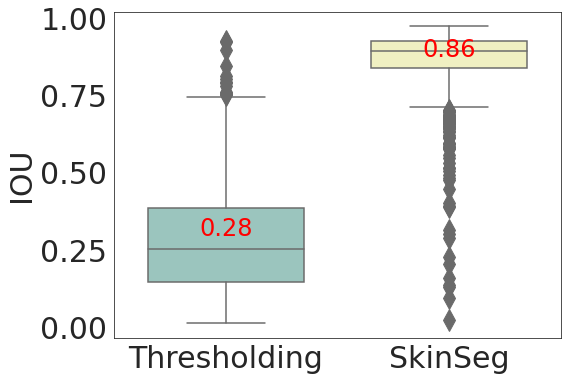

In [24]:
plt.figure(figsize=(8,6))

rc={'axes.labelsize': 30, 'font.size': 30, 'legend.fontsize': 24, 'axes.titlesize': 24}
plt.rcParams.update(**rc)

#boxplot
g1 = sns.boxplot(data = [naive['skin_iou'],swin['skin_iou']],fliersize=15,palette='Set3',width=0.7,saturation=0.6)
#add texts
means = [0.28,0.86]

#g1 = sns.swarmplot(data = data[['picture_o','price_o','text_o','rating_o']], color='0.3')
g1.set(xticklabels=['Thresholding','SkinSeg'])
#plt.title('Boxplots of IoU scores')
plt.ylabel('IOU')

pos1 = g1.get_position(original=False) # get the original position 
pos2 = [text.get_position() for text in g1.get_xticklabels()]

xwidth =  pos1.x1/3
ywidth =  pos1.y1/3

dists = [0.1,0.2]
for idx, m in enumerate(means):
    #plt.text(pos1.x0+idx*xwidth, pos1.y0+idx*ywidth, '%.0f' % m, ha='center', va= 'bottom',fontsize=12)
    plt.text(idx, m, f'{m:.2f}', ha='center', va= 'bottom',fontsize=24, color='red',)

#plt.savefig('../result1/figures/Seg_performance_boxplots_.png',dpi=300,bbox_inches = 'tight')
plt.show()

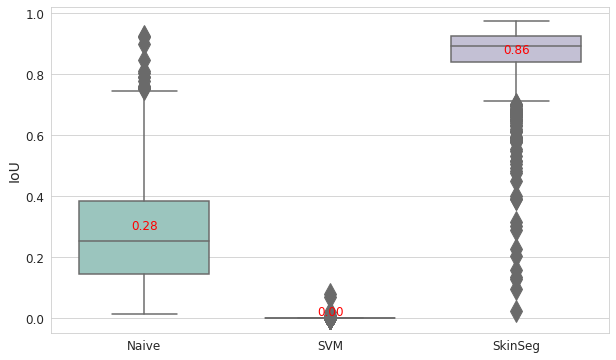

In [8]:
plt.figure(figsize=(10,6))
#boxplot
g1 = sns.boxplot(data = [naive['skin_iou'],svm['skin_iou'],swin['skin_iou']],fliersize=15,palette='Set3',width=0.7,saturation=0.6)
#add texts
means = [0.28,0.00,0.86]

#g1 = sns.swarmplot(data = data[['picture_o','price_o','text_o','rating_o']], color='0.3')
g1.set(xticklabels=['Naive','SVM','SkinSeg'])
#plt.title('Boxplots of IoU scores')
plt.ylabel('IoU')

pos1 = g1.get_position(original=False) # get the original position 
pos2 = [text.get_position() for text in g1.get_xticklabels()]

xwidth =  pos1.x1/3
ywidth =  pos1.y1/3

dists = [0.1,0.2,0.3]
for idx, m in enumerate(means):
    #plt.text(pos1.x0+idx*xwidth, pos1.y0+idx*ywidth, '%.0f' % m, ha='center', va= 'bottom',fontsize=12)
    plt.text(idx, m, f'{m:.2f}', ha='center', va= 'bottom',fontsize=12, color='red',)

#plt.savefig('../result/figures/methods_performance_boxplots.png',dpi=300,bbox_inches = 'tight')
plt.show()